# Imports

In [1]:
import sys
sys.path.append('/home/jovyan/work/sem-covid/')
sys.path = list(set(sys.path))

import os
os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import matplotlib.pyplot as plt

from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls, clean_remove_numbers
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import spacy_stop_words

from plsa.preprocessors import tokenize
from plsa.preprocessors import LemmatizeWords
from plsa.preprocessors import remove_short_words
from plsa import Corpus, Pipeline, Visualize
from plsa.algorithms import PLSA

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
2021-08-07 10:19:40.307251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-07 10:19:40.307271: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Global variables

In [2]:
CUSTOM_PREPROC_PIPELINE = (
    tokenize,
    LemmatizeWords('NN'),
    remove_short_words(3)
)

NR_TOPICS = 10

# Methods

In [3]:
def remove_stop_words(txt):
    txt_no_sw = ' '.join([word for word in txt.split() if word.lower() not in spacy_stop_words])
    
    return txt_no_sw

# Fetch the data

In [4]:
pwdb = Dataset.PWDB.fetch()

pwdb.fillna(value='', inplace=True)

document_corpus = pwdb['title'].map(str) + ' ' + \
                  pwdb['background_info_description'].map(str) + ' ' + \
                  pwdb['content_of_measure_description'].map(str)

100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [5]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", ")", "\n", "*", "1)", "2)", 
                     "3)", "[", "]", "-", "_", "\r", "=", "!", ",", ".", "?", ":", "/"]

document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls, replace_with=' ')
document_corpus = document_corpus.apply(clean_remove_emails, replace_with=' ')
document_corpus = document_corpus.apply(clean_remove_currency_symbols, replace_with=' ')
document_corpus = document_corpus.apply(clean_remove_numbers, replace_with=' ')
document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)

In [6]:
document_corpus_no_sw = []

for doc in document_corpus:
    document_corpus_no_sw.append(remove_stop_words(doc))

In [7]:
document_corpus_no_sw[0]

'agreement teleworking regime covid crisis teleworking identified vital pillar companies working prevent social hardship discussions representative social partners ogbl lcgb employer association uel ministry work employment led instance joint assessment teleworking level economic social council ces discussions continued social partners inter professional agreement signed social partners october applied period years covering sectors luxembourg exception transport agreement provides definition teleworking teleworking identified form organisational work conducted digital means usually company transferred location employee lives work considered teleworking applied occasional exceptional circumstances remains threshold annual working time teleworking based written agreement employer employee containing compulsory elements example location telework takes place number hours employee t dismissed accept teleworking scheme employer t accountable employer refuses teleworking scheme employer provi

# Main

In [8]:
preproc_pipeline = Pipeline(*CUSTOM_PREPROC_PIPELINE)
preproc_pipeline

Pipeline:
0: tokenize
1: LemmatizeWords
2: short_word_remover

In [9]:
corpus = Corpus(document_corpus_no_sw, preproc_pipeline)
corpus

Corpus:
Number of documents: 1288
Number of words:     5748

In [10]:
plsa = PLSA(corpus, NR_TOPICS, True)
result = plsa.fit()

In [11]:
visualize = Visualize(result)
visualize

Visualize:
Number of topics:    10
Number of documents: 1288
Number of words:     5748

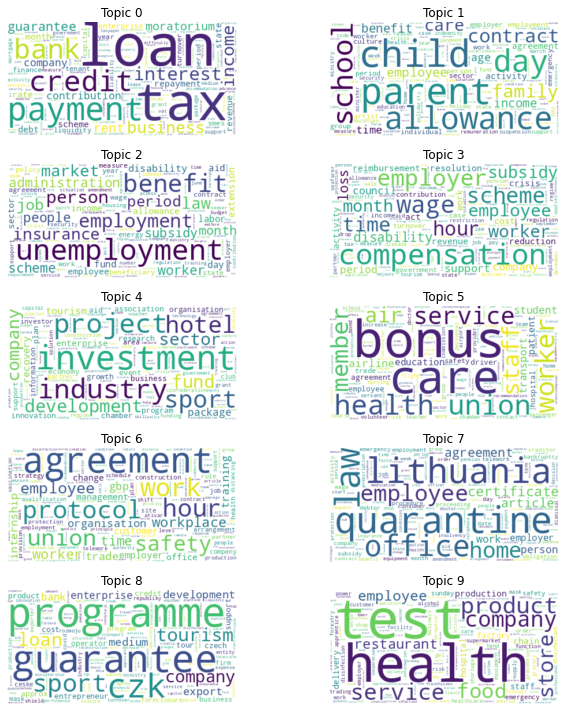

In [12]:
fig = plt.figure(figsize=(10, 10))
_ = visualize.wordclouds(fig)

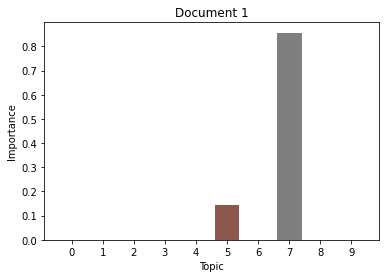

In [13]:
fig, ax = plt.subplots()
_ = visualize.topics_in_doc(1, ax)